In [9]:
# import packages and existing code/functions

import glob
import os
from lsst import afw
print(afw.version.__version__)
from lsst.daf.persistence import Butler
from lsst.eotest.sensor import MaskedCCD, makeAmplifierGeometry
import numpy

from exploreRun import exploreRun
from lsst.eo_utils.base.image_utils import get_ccd_from_id,\
    get_amp_list, get_data_as_read, sort_sflats

from lsst.eo_utils.base.data_access import get_data_for_run

import lsst.eotest.image_utils as imutil
import pylab

from astropy.io import fits
from astropy.stats import mad_std
import numpy as np

import scipy
from scipy import signal
from scipy.fftpack import fft, fftshift
import matplotlib.pyplot as plt

import math

%matplotlib inline

20.0.0-4-gde602ef96+1


In [10]:
# set up file paths for ts8 to make combined flat displaying full sensor

# looking at Raft 13, CCD 21, run 10982 (must be a good run) .... same as in testing_making_flat_from_lamda notebook

superbiaspath = "/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superbias/RTM-013/RTM-013-10982-S21_superbias_normal.fits"
superdarkpath = "/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superdark/RTM-013/RTM-013-10982-S21_superdark_normal.fits"
qeflatpath = glob.glob("/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-11021_RTM/LCA-11021_RTM-013/10982/qe_raft_acq/v0/85192/S21/*_lambda_flat_*")
qeflatpath.sort()

In [11]:
# array of wavelengths

wls = numpy.array([ get_ccd_from_id(None, aqeflatpath, []).md.md["MONOWL"] for aqeflatpath in qeflatpath ])
print(wls)

[ 319.994  324.969  349.982  374.975  400.019  424.965  450.035  475.003
  500.018  525.002  550.029  575.023  599.982  619.997  624.979  650.012
  675.004  700.03   725.012  750.022  774.987  799.976  824.988  850.022
  869.967  875.002  899.999  919.999  925.012  949.965  975.002  999.976
 1025.028 1050.014 1075.002 1099.99 ]


[1.15429078e-017 4.05581626e-014 1.30240668e-002 1.47383243e-001
 5.60866589e-011 1.02343173e-030 3.63772687e-061 6.36388808e-102
 3.73616607e-153 7.95497194e-215 5.70088782e-287 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]


Text(0.5, 1.0, 'Response Curve/SED for CCOB$_{B}$')

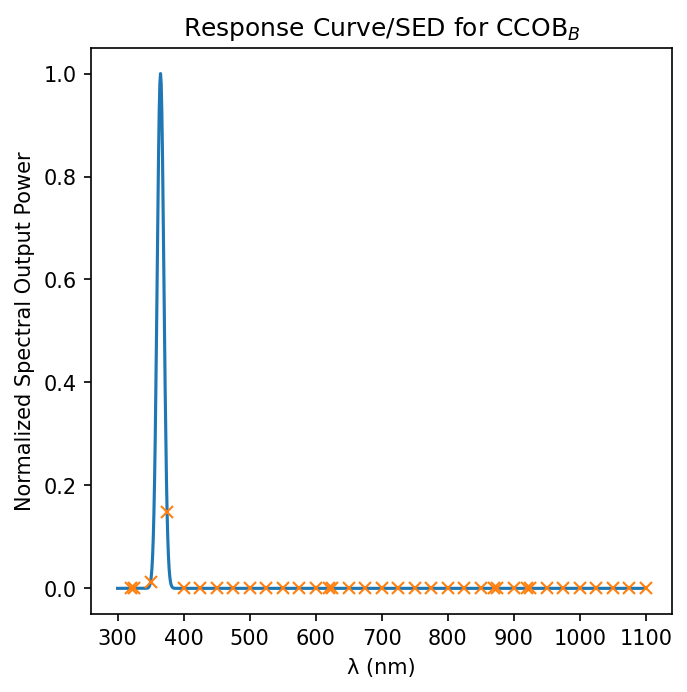

In [12]:
# response function at BLUE band using LSST filters, not SDSS

# x and y functions are a numpy.array , they replace the sdssfilter[2].data["wavelength"] and sdssfilter[2].data["respt"] respectively


fig, axs = pylab.subplots(figsize=(5,5),dpi=150)
# [('wavelength', '>f4'), ('respt', '>f4'), ('resbig', '>f4'), ('resnoa', '>f4'), ('xatm', '>f4')]

wavelengths_list = [365, 466.6, 622.6, 759.9, 845.7, 950.5]
width_of_wavelength_list = [12, 25, 18, 28, 32, 60]
width_of_wavelength_list_converted = []
for num in width_of_wavelength_list:
    z = num / 2.355
    width_of_wavelength_list_converted.append(z)
# now wavelength widths converted from FWHM to sigma


# want to use the blue band, so the first element in each list
mu = wavelengths_list[0]
sigma = width_of_wavelength_list_converted[0]

a = 1    # to normalize
x = numpy.arange(300,1100,1)  
         # gaussians #
y = a*numpy.exp(-(x-mu)**2/(2*sigma**2))
# plots the gaussians
pylab.plot(x, y)

# corrects for the difference in resolution for each wavelength in wls, it will interpolate numbers at wls*10 for this case.
# interpolation is a method of curve fitting using linear polynomials to construct NEW data points within the range of a discrete set of KNOWN data points
weights = numpy.interp(wls, x, y)
print(weights)
# plots 'x's
pylab.plot(wls, weights,"x")


# labeling plot
pylab.xlabel("λ (nm)")
pylab.ylabel("Normalized Spectral Output Power")
pylab.title("Response Curve/SED for CCOB$_{B}$")

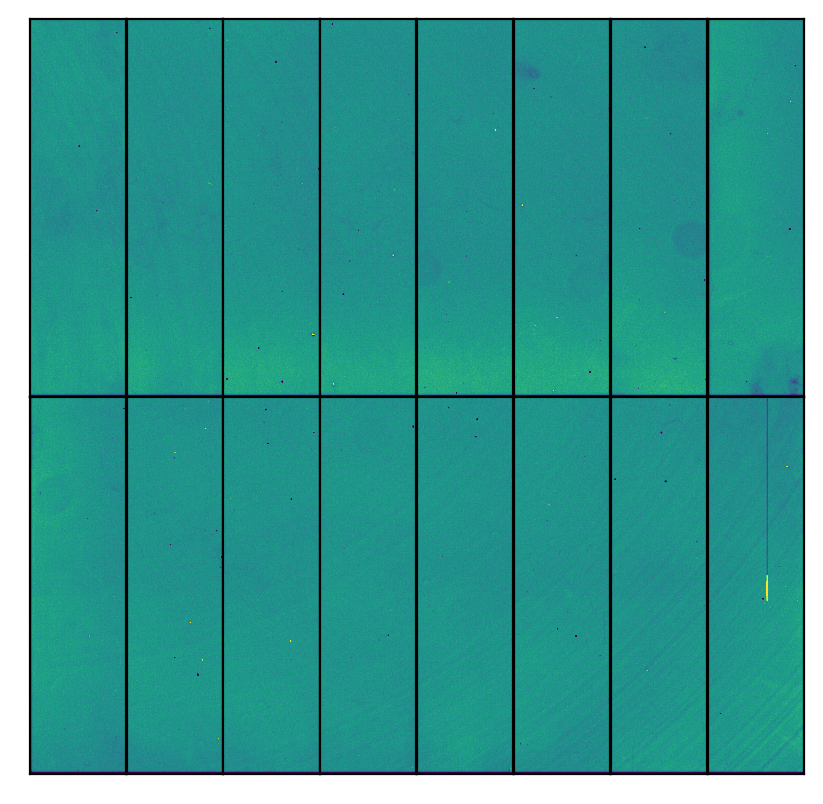

In [148]:
### GOAL: show combined flat for full sensor (all amplifiers) ###


import numpy as np
import matplotlib.pyplot as plt

superdark = get_ccd_from_id(None, superdarkpath, [])     # load superdark
superbias = get_ccd_from_id(None, superbiaspath, [])     # load superbias


num_ch  = 16    # number of channels/amplifiers/segments in CCD
img_list = []

# loops over each amplifier in the CCD
for ch in range(num_ch):
    arr = []        # defines an empty array for storing new combined flat for each amplifier
    for i, aqeflatpath in enumerate(qeflatpath):
        aqeflat = get_ccd_from_id(None, aqeflatpath, [], bias_frame=superbias)

        img = aqeflat.unbiased_and_trimmed_image(ch + 1).getImage().array
        img = img/img.mean()     # this will normalize your image

        arr.append(img*weights[i])
        arr.append(img*weights[i])
        
    img = numpy.sum(arr,axis=0)/numpy.sum(weights) 
    mean = img.mean()
    std = mad_std(img)
    N = 3
    
    # puts images into a list to use below
    img_list.append(img)



    
# Let's see how the Combined flat for FULL CCD SENSOR looks
# creating a broadband flat (Combined) from summed up narrow band flats weighted by QE response!!!

fig=plt.figure(figsize=(5, 5), dpi=200)   # dpi : dot per inch
columns = 8
rows = 2

#ax = []    # in case we want to use titles 
for i in range(1, (columns*rows) + 1):
    image = img_list[i - 1]
    ax1 = fig.add_subplot(rows, columns, i)
    
    #ax.append(ax1)
    #ax[-1].set_title("ch "+str(i), fontsize=7)
    
    ax1.set_xticks([])   # getting rid of axis ticks and numbering
    ax1.set_yticks([])
    
    plt.imshow(image, vmin=mean-N*std,vmax=mean+N*std,origin="lower")

# getting rid of space between subplots horizontally and vertically
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()


In [171]:
blue_img_list = []
red_img_list = []
normedimg_img_list = []

for ch in range(num_ch):
    fname = "/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R02_S21_red_-211.815_-0.395.fits"
    ccob_red = get_ccd_from_id(None, fname, [])
    print ( mad_std(get_data_as_read(ccob_red,ch + 1,["imaging"])["imaging"]))
    fname = "/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R02_S21_uv_-211.815_-0.395.fits"
    ccob_blue = get_ccd_from_id(None, fname, [])
    print ( mad_std(get_data_as_read(ccob_blue,ch + 1,["imaging"])["imaging"]))

    # normalize flat 
    red = get_data_as_read(ccob_red,ch + 1,["imaging"])["imaging"]   # this is the CCOB(red) flat image
    blue = get_data_as_read(ccob_blue,ch + 1,["imaging"])["imaging"] # this is the CCOB(blue) flat image
    blue_img_list.append(blue)
    red_img_list.append(red)

    # changed this normalization to blue!! this is basically the combined flat normalized with CCOB(blue), so the "new combined" flat image
    normedimg = img_list[ch]/img_list[ch].mean()*blue.mean()
    normedimg_img_list.append(normedimg)

#print(blue_img_list)
#print(red_img_list)

464.05449439225345
431.4372455851302
447.7458699886918
416.61122340007415
444.7806655516806
415.1286211815686
441.8154611146694
407.7156100890406
441.8154611146694
415.1286211815686
438.8502566776582
416.61122340007415
437.3676544591526
416.61122340007415
446.2632677701862
428.472041148119
443.298063333175
424.0242344926022
437.3676544591526
406.23300787053495
438.8502566776582
409.19821230754616
441.8154611146694
406.23300787053495
438.8502566776582
409.19821230754616
440.3328588961638
407.7156100890406
443.298063333175
418.0938256185798
461.08928995524224
449.2284722071974


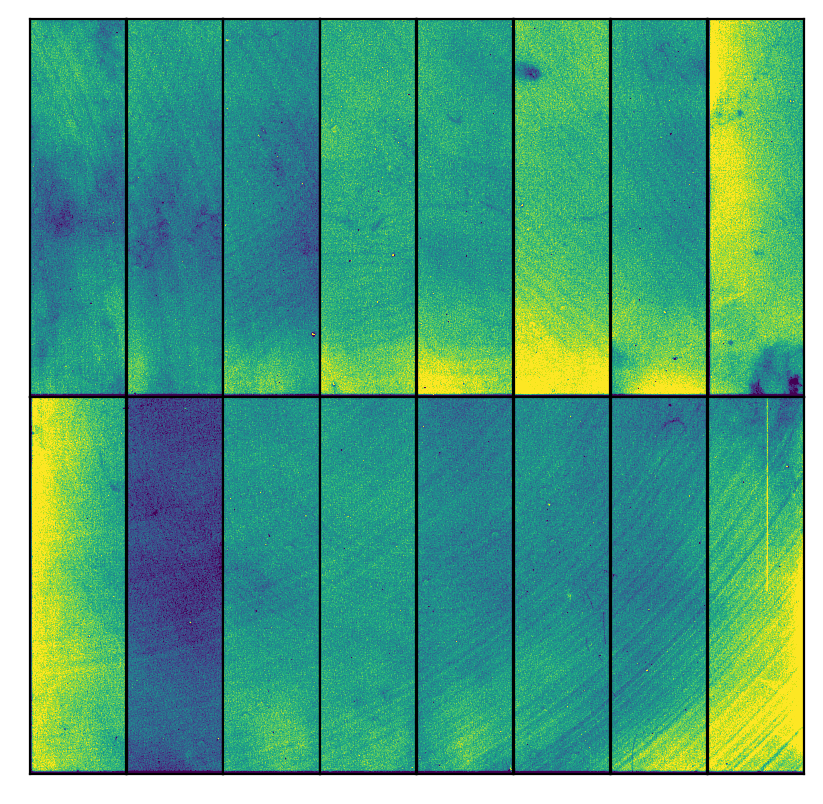

In [168]:
### GOAL: show CCOB(blue) flat for full sensor (all amplifiers) ###

fig=plt.figure(figsize=(5, 5), dpi=200)   # dpi : dot per inch
columns = 8
rows = 2

#ax = []    # in case we want to use titles 
for i in range(1, (columns*rows) + 1):
    image = blue_img_list[i - 1]                                           # CCOB BLUE #
    ax1 = fig.add_subplot(rows, columns, i)
    
    #ax.append(ax1)
    #ax[-1].set_title("ch "+str(i), fontsize=7)
    
    ax1.set_xticks([])   # getting rid of axis ticks and numbering
    ax1.set_yticks([])
    
    plt.imshow(image, vmin=mean-N*std,vmax=mean+N*std,origin="lower")

# getting rid of space between subplots horizontally and vertically
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()


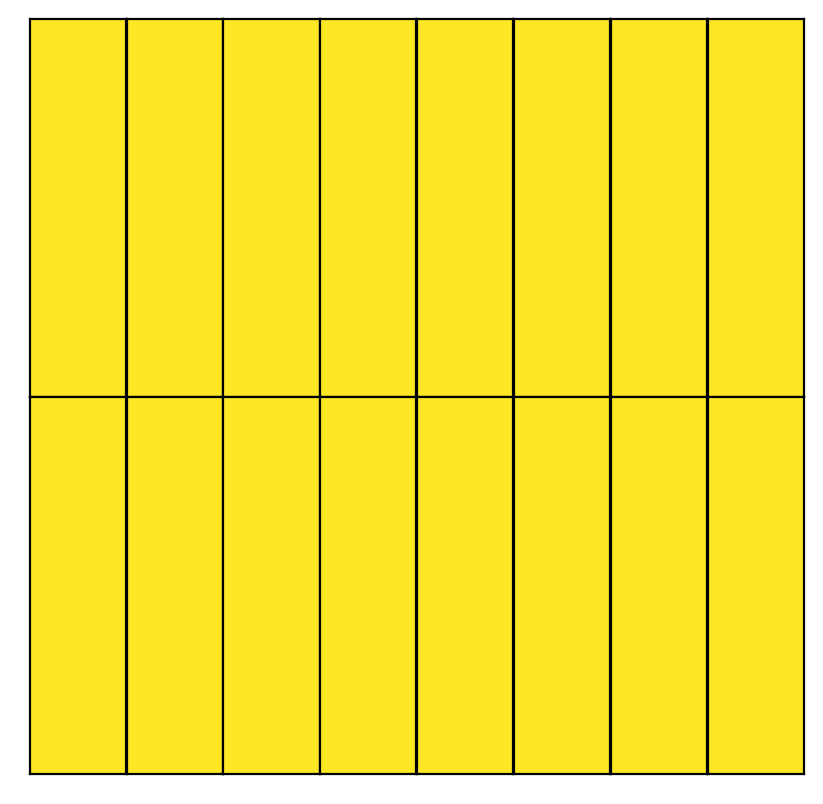

In [169]:
### GOAL: show CCOB(red) flat for full sensor (all amplifiers) ###

fig=plt.figure(figsize=(5, 5), dpi=200)   # dpi : dot per inch
columns = 8
rows = 2

#ax = []    # in case we want to use titles 
for i in range(1, (columns*rows) + 1):
    image = red_img_list[i - 1]                                                    # CCOB RED #
    ax1 = fig.add_subplot(rows, columns, i)
    
    #ax.append(ax1)
    #ax[-1].set_title("ch "+str(i), fontsize=7)
    
    ax1.set_xticks([])   # getting rid of axis ticks and numbering
    ax1.set_yticks([])
    
    plt.imshow(image, vmin=mean-N*std,vmax=mean+N*std,origin="lower")

# getting rid of space between subplots horizontally and vertically
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

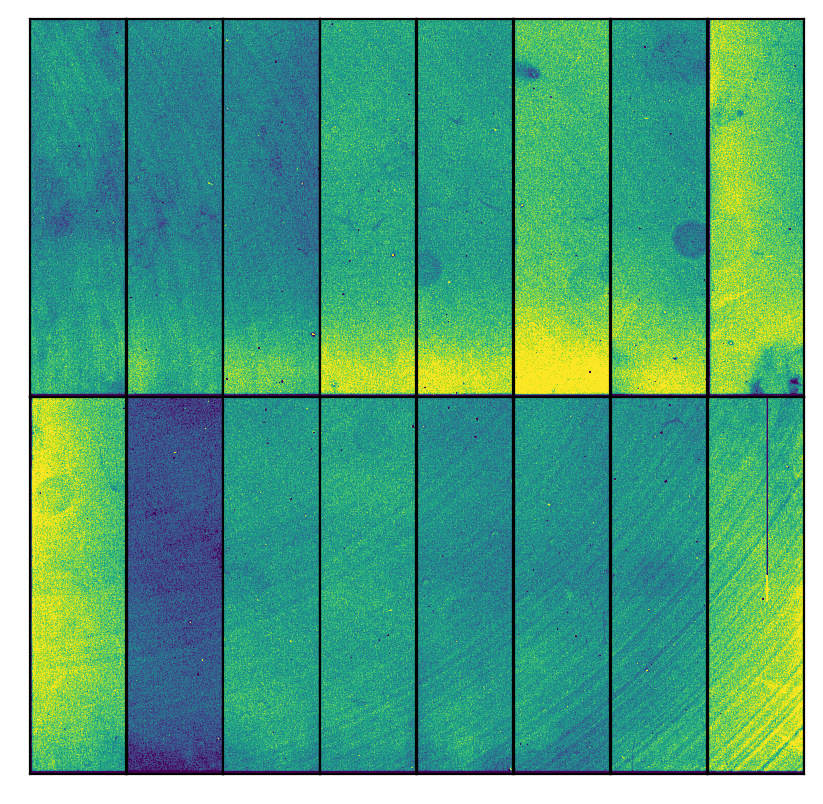

In [170]:
### GOAL: show normeding flat (combined but as normalized to CCOB(blue) for full sensor (all amplifiers) ###

fig=plt.figure(figsize=(5, 5), dpi=200)   # dpi : dot per inch
columns = 8
rows = 2

#ax = []    # in case we want to use titles 
for i in range(1, (columns*rows) + 1):
    image = normedimg_img_list[i - 1]                                     #  NORMEDIMG (combined but as normalized to CCOB(blue) #
    ax1 = fig.add_subplot(rows, columns, i)
    
    #ax.append(ax1)
    #ax[-1].set_title("ch "+str(i), fontsize=7)
    
    ax1.set_xticks([])   # getting rid of axis ticks and numbering
    ax1.set_yticks([])
    
    plt.imshow(image, vmin=mean-N*std,vmax=mean+N*std,origin="lower")

# getting rid of space between subplots horizontally and vertically, horizontal spacing not working though!!
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

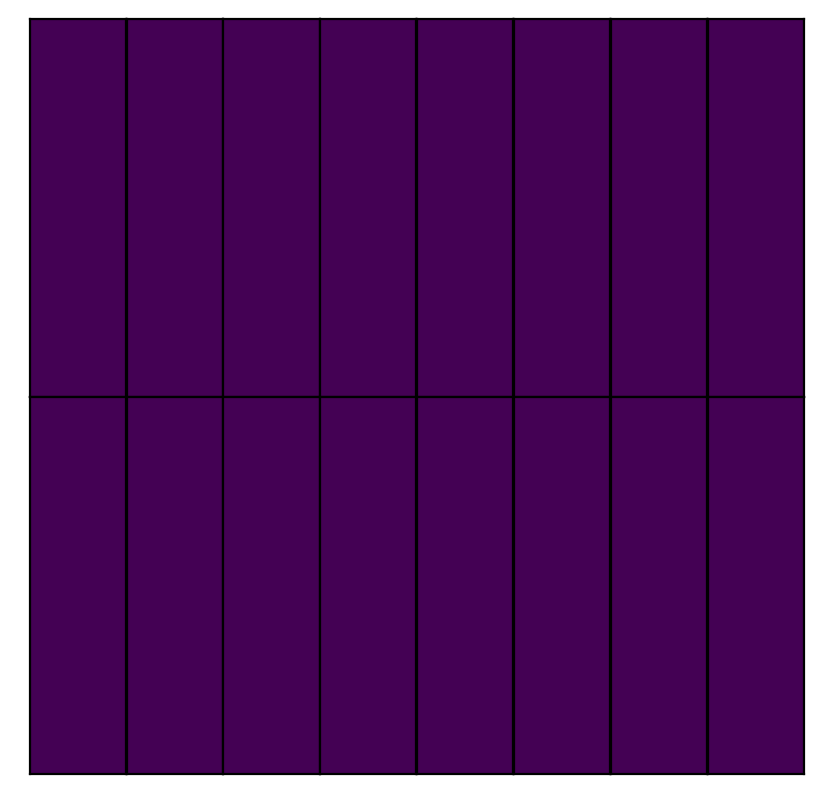

In [172]:
### GOAL: show ratio flat (combined/normedinmg vs. CCOB(blue)) for full sensor (all amplifiers) ###

fig=plt.figure(figsize=(5, 5), dpi=200)   # dpi : dot per inch
columns = 8
rows = 2

#ax = []    # in case we want to use titles 
for i in range(1, (columns*rows) + 1):
    image = ((normedimg_img_list[i - 1]) - (blue_img_list[i - 1])) / (blue_img_list[i - 1])                           # RATIO #
    ax1 = fig.add_subplot(rows, columns, i)
    
    #ax.append(ax1)
    #ax[-1].set_title("ch "+str(i), fontsize=7)
    
    ax1.set_xticks([])   # getting rid of axis ticks and numbering
    ax1.set_yticks([])
    
    plt.imshow(image, vmin=mean-N*std,vmax=mean+N*std,origin="lower")

# getting rid of space between subplots horizontally and vertically, horizontal spacing not working though!!
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()




479.74343739979906
479.74343739979906
479.74343739979906
479.74343739979906
479.74343739979906
479.74343739979906
479.74343739979906
479.74343739979906
479.74343739979906
479.74343739979906
479.74343739979906
479.74343739979906
479.74343739979906
479.74343739979906
479.74343739979906


IndexError: list index out of range

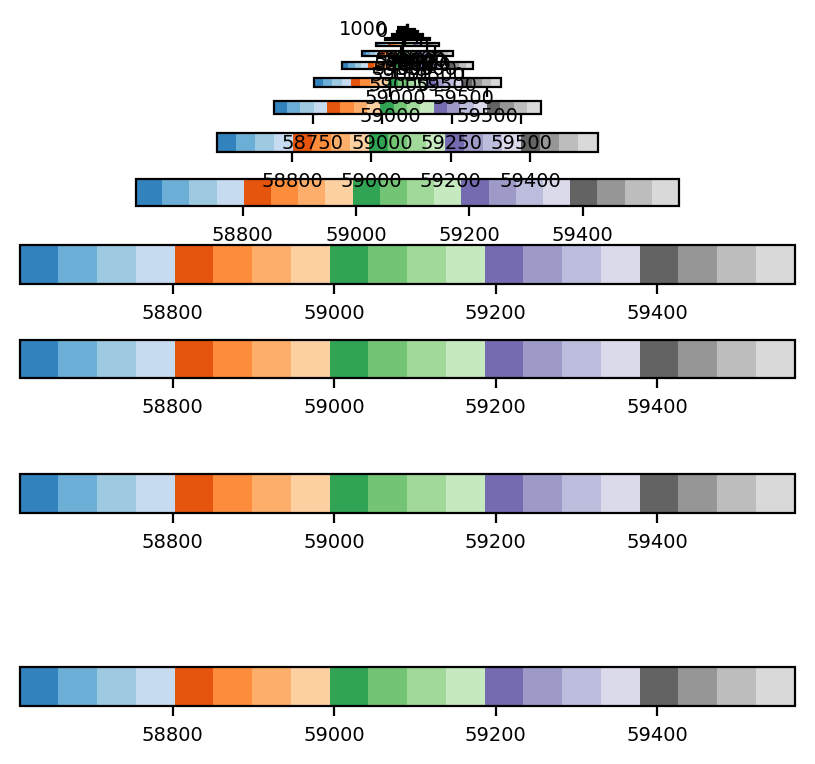

In [200]:

fig=plt.figure(figsize=(5, 5), dpi=200)   # dpi : dot per inch
columns = 8
rows = 2

#ax = []    # in case we want to use titles 
for i in range(1, (columns*rows) + 1):
    mean = numpy.median(animg)
    std = mad_std(animg)
    N = 1
    #ax.set_title(label)
    im = plt.imshow(blue_img_list[i],vmin=mean-N*std,vmax=mean+N*std,origin="lower",cmap=pylab.get_cmap("tab20c"))
    fig.colorbar(im, orientation="horizontal")
    print(std)
    
#print(animg)
#print(axs)
#print(ax)
#print(label)
